<center><h1> HEAD 2023 DATA TWITTER ANALYSIS

In [243]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import os
import json

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('words')
words = set(nltk.corpus.words.words())
nltk.download('punkt');

import re
from wordcloud import WordCloud, STOPWORDS 
import requests

import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from string import punctuation
from collections import OrderedDict

import pyLDAvis
import pyLDAvis.gensim_models

import plotly.graph_objs as go
import plotly.express as px
# pd.options.plotting.backend = "plotly"
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

import data_cleaning as dc


pyLDAvis.enable_notebook()
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/raphael/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to /Users/raphael/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /Users/raphael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# read data from api
file_path = 'data.json'
data = read_json_file(file_path)

In [6]:
data[1]

{'Tweet content': 'You want to see funny? Go back and look at some of the old Hamilton LRT proposals from like 2021 when the province and feds were arguing over funding.',
 'Date': '2023-05-22 00:05:36',
 'Location': 'Ottawa, Ontario',
 'Hashtags': 'No hashtags'}

In [7]:
# visualise

df = pd.DataFrame(data)
df.head()

,Tweet content,Date,Location,Hashtags
0,"Hamilton PSA Road Delay. Last Week.\n\nUNM PATS is notifying the UNM community to expect HEAVY VEHICLE AND FOOT TRAFFIC from May 22 to May 28, due to special events, including the Hamilton Broadway Musical at Popejoy Hall.\n\nRead the full notice at https://t.co/m0FXPO48dJ https://t.co/hZEnc4t78p",2023-05-22 23:00:00,"Albuquerque, NM",No hashtags
1,You want to see funny? Go back and look at some of the old Hamilton LRT proposals from like 2021 when the province and feds were arguing over funding.,2023-05-22 00:05:36,"Ottawa, Ontario",No hashtags
2,@SocialistFox @SocialistFT No municipality should be paying for stadiums. The billionaires can pay their own way. The problem is in Hamilton you know the city council will vote for that while they continue to stifle public transit.,2023-05-19 13:34:43,Ontario,No hashtags
3,Weigh in on the proposed HSR network redesign! \n\n#HamOnt #Hamilton #publictransit @cityofhamilton @hsr \n\nhttps://t.co/AtxwjQmVkq,2023-05-19 13:32:46,"Hamilton, Ontario","#HamOnt, #Hamilton, #publictransit"
4,@ArizonaCoyotes Hamilton right by Toronto within public transit range even of Toronto is a no brainer as well. Would absolutely kill all US markets in profits. \n\nEven a team in Saskatchewan would make more than most US markets if not all.,2023-05-19 07:37:45,No location provided,No hashtags


### Basic Data Exploration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet content  5238 non-null   object
 1   Date           5238 non-null   object
 2   Location       5238 non-null   object
 3   Hashtags       5238 non-null   object
dtypes: object(4)
memory usage: 163.8+ KB


In [9]:
# convert date column to correct format
df['Date'] =  pd.to_datetime(df['Date'])

# make individual column for date and time
df['Dates'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Date']).dt.time

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tweet content  5238 non-null   object        
 1   Date           5238 non-null   datetime64[ns]
 2   Location       5238 non-null   object        
 3   Hashtags       5238 non-null   object        
 4   Dates          5238 non-null   object        
 5   Time           5238 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 245.7+ KB


<AxesSubplot:title={'center':'Time Series Analysis of Tweets'}>

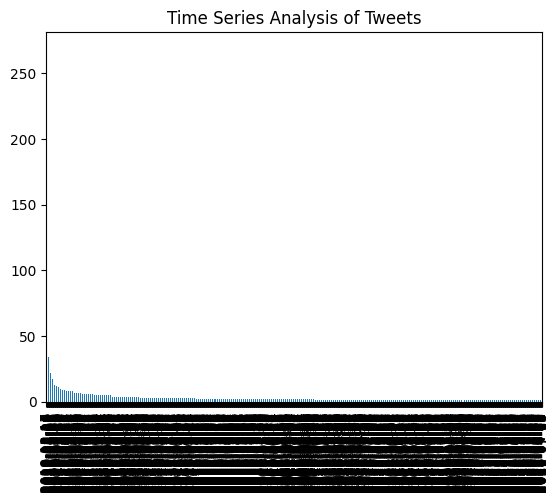

In [11]:

# visualize the time series 
df['Dates'].value_counts().plot(kind = 'bar', title = 'Time Series Analysis of Tweets')

In [13]:
# Create new columns
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238 entries, 0 to 5237
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tweet content  5238 non-null   object        
 1   Date           5238 non-null   datetime64[ns]
 2   Location       5238 non-null   object        
 3   Hashtags       5238 non-null   object        
 4   Dates          5238 non-null   object        
 5   Time           5238 non-null   object        
 6   day            5238 non-null   int64         
 7   month          5238 non-null   int64         
 8   year           5238 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 368.4+ KB


<AxesSubplot:>

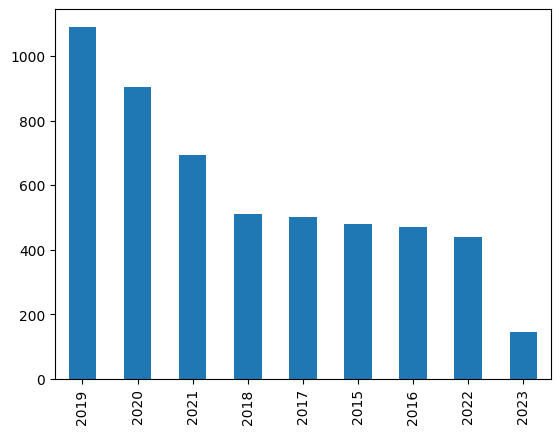

In [17]:
df['year'].value_counts()/len(df.Dates)*100
df['year'].value_counts().plot.bar()

In [19]:
# create new colums to store # and @
df['Hashtags'] = df['Tweet content'].str.findall(r'#.*?(?=\s|$)')
df['mentions'] = df['Tweet content'].str.findall(r'[＠@]([^][\s#<>|{}]+)')

In [20]:
df.head(2)

,Tweet content,Date,Location,Hashtags,Dates,Time,day,month,year,mentions
0,"Hamilton PSA Road Delay. Last Week.\n\nUNM PATS is notifying the UNM community to expect HEAVY VEHICLE AND FOOT TRAFFIC from May 22 to May 28, due to special events, including the Hamilton Broadway Musical at Popejoy Hall.\n\nRead the full notice at https://t.co/m0FXPO48dJ https://t.co/hZEnc4t78p",2023-05-22 23:00:00,"Albuquerque, NM",[],2023-05-22,23:00:00,22,5,2023,[]
1,You want to see funny? Go back and look at some of the old Hamilton LRT proposals from like 2021 when the province and feds were arguing over funding.,2023-05-22 00:05:36,"Ottawa, Ontario",[],2023-05-22,00:05:36,22,5,2023,[]


In [25]:
# create a new function to clean the tweets 
def remove_hashtags_usernames(tweet):
    # Use regex to match hashtags (starting with #) and usernames (starting with @)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

cleaned_tweets = []
for tweet in df['Tweet content']:
    cleaned_tweet = remove_hashtags_usernames(tweet)
    cleaned_tweet = re.sub('\W+',' ', cleaned_tweet )
    cleaned_tweets.append(cleaned_tweet)
    
df['cleaned_tweets'] = cleaned_tweets


In [273]:
# Create a stopword document
comment_words = '' 
add_stop = ['ford','toronto',"accessibletransportation",'go', 'via',
"publictransit",
"hamiltontransit",
"disabilitytransportation",
"inclusivetransportation",
"accessibletravel",
"transportationservices",
"accessiblecommute",
"hamiltonats",
"hamiltonlrt (for light rail transit)",
"hamiltongo (for go transit)",
"transportationdata",
"mobilityoptions",
"transitaccessibility",
"transportationanalytics",
"transportationinsights",
"tripdata",
"transportationdemand",
"urbantransit"'will',
'need',
'want',
'https', 
'rt', 
're',
'the',
'in',
'is',
'it',
'on',
'amp',
'us',
'a',
'i',
'will',
'u',
's',
'dont',
't',
're',
'don',
'm',
've', 
'i',
'1', '2', '3', '4','5','6', '7', '8', '9','0',
'hamilton',
'transit',
'hamilton transit',
'S','public', 'lrt', 'project', 'ontario', 'new','province', 'city', 'say', 'now']
stopwords = set(list(STOPWORDS)+add_stop)


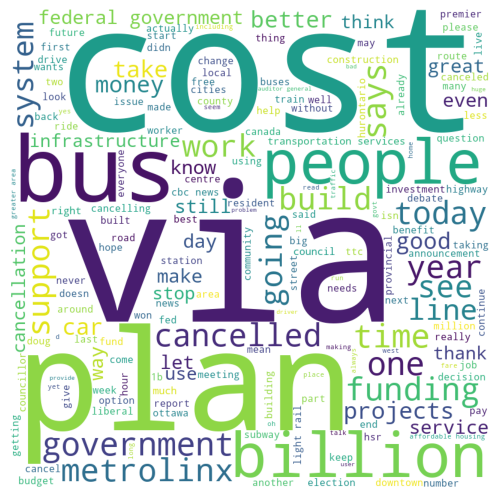

In [274]:
# Create a word cloud

df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stopwords)]))

for val in df['cleaned_tweets']: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

plt.figure( facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()



In [275]:
# Define the sentiment objects using SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


sentiment_objects = [sia.polarity_scores(tweet) for tweet in df['cleaned_tweets']]



In [276]:
# look at an example
sentiment_objects[0]


{'neg': 0.07, 'neu': 0.848, 'pos': 0.082, 'compound': 0.1027}

In [277]:
# Create a list of polarity values and tweet text

sentiment_values = [sentiment_object['compound'] for sentiment_object in sentiment_objects]

# Print the value of the 0th row.

sentiment_values[0]
# Print all the sentiment values

sentiment_values[0:2]


[0.1027, -0.0258]

In [278]:
# Create a dataframe of each tweet against its polarity

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity"])
sentiment_df.head()
df['polarity'] = sentiment_df['polarity']


In [279]:
# visaulise the table to check the update
df.head(2)


,Tweet content,Date,Location,Hashtags,Dates,Time,day,month,year,mentions,cleaned_tweets,polarity,Sentiment,words,cleaned_words,cleaned_words_c,topic
0,"Hamilton PSA Road Delay. Last Week.\n\nUNM PATS is notifying the UNM community to expect HEAVY VEHICLE AND FOOT TRAFFIC from May 22 to May 28, due to special events, including the Hamilton Broadway Musical at Popejoy Hall.\n\nRead the full notice at https://t.co/m0FXPO48dJ https://t.co/hZEnc4t78p",2023-05-22 23:00:00,"Albuquerque, NM",[],2023-05-22,23:00:00,22,5,2023,[],psa road delay last week unm pats notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special events including broadway musical popejoy hall read full notice,0.1027,Negative,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",psa road delay last week unm pat notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special event including broadway musical popejoy hall read full notice,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",Government Support and News Announcements
1,You want to see funny? Go back and look at some of the old Hamilton LRT proposals from like 2021 when the province and feds were arguing over funding.,2023-05-22 00:05:36,"Ottawa, Ontario",[],2023-05-22,00:05:36,22,5,2023,[],see funny back look old proposals 2021 feds arguing funding,-0.0258,Negative,"[see, funny, back, look, old, proposal, 2021, fed, arguing, funding]",see funny back look old proposal 2021 fed arguing funding,"[see, funny, back, look, old, proposal, 2021, fed, arguing, funding]",Bus Services and Costs


In [280]:
# Save the polarity column as 'n'.

n=sentiment_df["polarity"]

# Convert this column into a series, 'm'. 

m=pd.Series(n)


In [314]:
# Initialize variables, 'pos', 'neg', 'neu'.

pos=0
neg=0


sentiment = []
# Create a loop to classify the tweets as Positive, Negative, or Neutral.
# Count the number of each.

for items in m:
    if items>0.3 and items<=1:
        sentiment.append("Positive")
        pos=pos+1
    elif items<=0.3 and items >-1:
        sentiment.append("Negative")
        neg=neg+1
        
print(pos,neg)

1794 3444


In [315]:
# create a new column called sentiment
df['Sentiment'] = sentiment


<AxesSubplot:xlabel='year'>

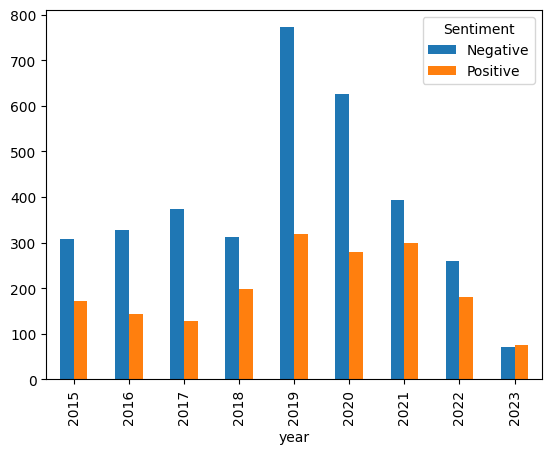

In [316]:
table_sent_count = pd.crosstab(df['year'],df['Sentiment']).reset_index().sort_values(by = 'year')
table_sent_count.plot(x = 'year', kind = 'bar')

In [317]:
# Create Line plot
fig = px.line(table_sent_count, x=table_sent_count["year"], y=table_sent_count['Negative'])
fig.add_scatter(x=table_sent_count["year"], y=table_sent_count['Positive'])
# fig.add_scatter(x=table_sent_count["year"], y=table_sent_count['Neutral'])
fig.update_traces(textposition='top center')

fig.update_layout(colorway = ['#7f7f7f', '#bcbd22', '#17becf'],
    title="Sentiment Time Series Analysis of Tweet Count",
    xaxis_title="year",
    yaxis_title="Setiment Count",
    legend_title="Sentiment",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"))
fig.show()


In [318]:
# split the sentance and liwer case it
e_words= [i.strip().lower().split(' ') for i in df['cleaned_tweets']]
e_words[2]



['municipality',
 'paying',
 'stadiums',
 'billionaires',
 'pay',
 'way',
 'problem',
 'know',
 'council',
 'vote',
 'continue',
 'stifle']

In [319]:
# use lemmarizing 
list_words = []
lemmatizer = WordNetLemmatizer()

for s in e_words:
    word = []
    for w in s:
        rootWord=lemmatizer.lemmatize(w)
        word.append(rootWord)
    list_words.append(word)
    
df['words'] = list_words
    

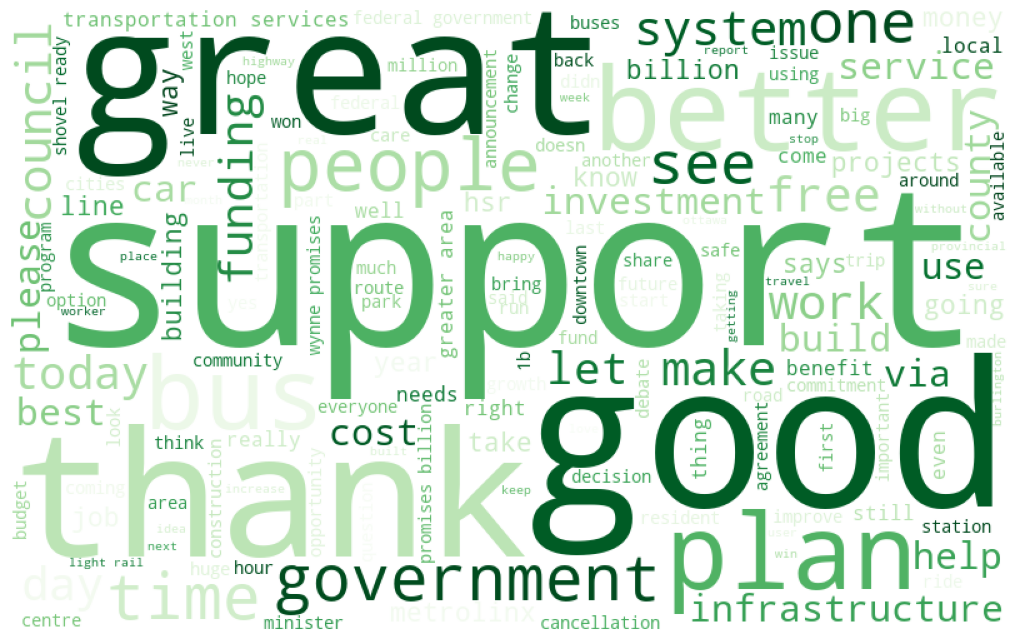

In [320]:
# create a word cloud for positive
df_pos = df.where(df["Sentiment"] == 'Positive')
df_pos.dropna(inplace = True)
comment_words_pos = ''
for val in df_pos['cleaned_tweets']: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words_pos += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords,
                      colormap = 'Greens',
                min_font_size = 10).generate(comment_words_pos)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


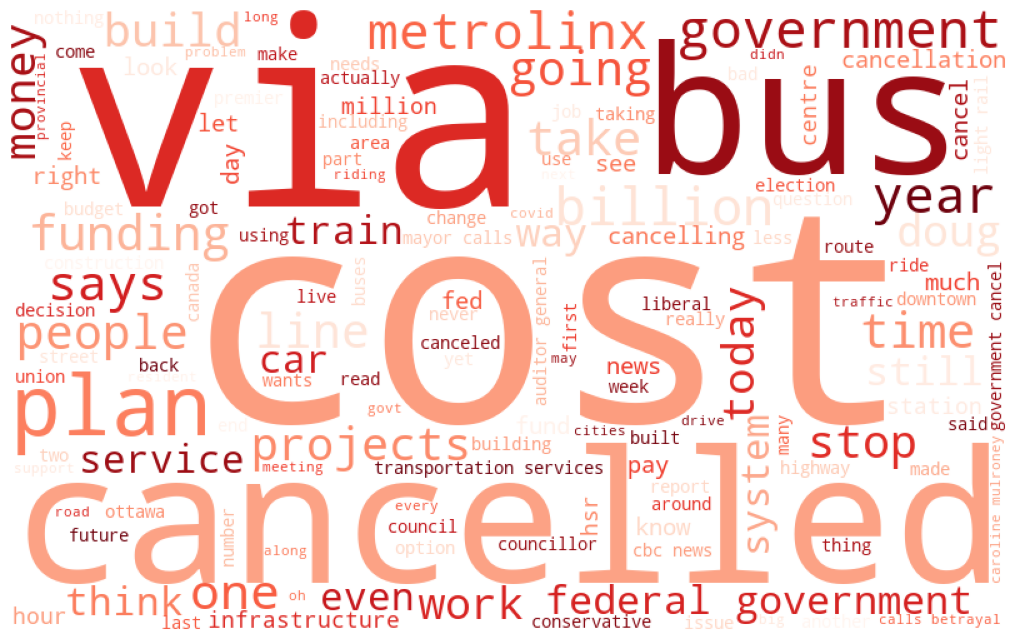

In [321]:
# create a negative 
df_neg = df.where(df["Sentiment"] == 'Negative')
df_neg.dropna(inplace = True)
comment_words_neg = ''
for val in df_neg['cleaned_tweets']: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words_neg += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords,
                      colormap = 'Reds',
                min_font_size = 10).generate(comment_words_neg)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()



## Topic Modelling

- <b>Create a document-term matrix:
</b> Create a document-term matrix using the text data. This matrix represents the number of times each word appears in each document.
<br>
+ <b>Apply TF-IDF:
</b>The second step is to apply TF-IDF (term frequency-inverse document frequency) to the document-term matrix. This helps to weight the words by how important they are in each document.
<br>
- <b>Train the LDA model:
</b> After applying TF-IDF, I will train the LDA (Latent Dirichlet Allocation) model on the document-term matrix. The LDA model is a type of unsupervised learning algorithm that can identify the underlying topics in the text data.
<br>
- <b>Evaluate the model:
</b> Once the LDA model is trained, I will evaluate it by calculating the coherence score. This score measures how well the topics are separated and how coherent the words in each topic are.
<br>
- <b>Interpret the topics:
</b> Finally, I will interpret the topics by examining the most common words in each topic and assigning a label or theme to each topic based on the words

In [289]:
# create a corpus of clean bag of words to develop a model
corpus_og=[]
cleaned_words_c = []
a=[]
for i in range(len(df['words'])):
    a = [word for word in df['words'][i] if word not in stopwords]
    corpus_og.append(' '.join(a))
    cleaned_words_c.append(a)
corpus_og[0]


'psa road delay last week unm pat notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special event including broadway musical popejoy hall read full notice'

In [290]:
# add to the original dataframe
df['cleaned_words']=corpus_og
df['cleaned_words_c']=cleaned_words_c
df.head()


,Tweet content,Date,Location,Hashtags,Dates,Time,day,month,year,mentions,cleaned_tweets,polarity,Sentiment,words,cleaned_words,cleaned_words_c,topic
0,"Hamilton PSA Road Delay. Last Week.\n\nUNM PATS is notifying the UNM community to expect HEAVY VEHICLE AND FOOT TRAFFIC from May 22 to May 28, due to special events, including the Hamilton Broadway Musical at Popejoy Hall.\n\nRead the full notice at https://t.co/m0FXPO48dJ https://t.co/hZEnc4t78p",2023-05-22 23:00:00,"Albuquerque, NM",[],2023-05-22,23:00:00,22,5,2023,[],psa road delay last week unm pats notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special events including broadway musical popejoy hall read full notice,0.1027,Negative,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",psa road delay last week unm pat notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special event including broadway musical popejoy hall read full notice,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",Government Support and News Announcements
1,You want to see funny? Go back and look at some of the old Hamilton LRT proposals from like 2021 when the province and feds were arguing over funding.,2023-05-22 00:05:36,"Ottawa, Ontario",[],2023-05-22,00:05:36,22,5,2023,[],see funny back look old proposals 2021 feds arguing funding,-0.0258,Negative,"[see, funny, back, look, old, proposal, 2021, fed, arguing, funding]",see funny back look old proposal 2021 fed arguing funding,"[see, funny, back, look, old, proposal, 2021, fed, arguing, funding]",Bus Services and Costs
2,@SocialistFox @SocialistFT No municipality should be paying for stadiums. The billionaires can pay their own way. The problem is in Hamilton you know the city council will vote for that while they continue to stifle public transit.,2023-05-19 13:34:43,Ontario,[],2023-05-19,13:34:43,19,5,2023,"[SocialistFox, SocialistFT]",municipality paying stadiums billionaires pay way problem know council vote continue stifle,-0.4767,Negative,"[municipality, paying, stadium, billionaire, pay, way, problem, know, council, vote, continue, stifle]",municipality paying stadium billionaire pay way problem know council vote continue stifle,"[municipality, paying, stadium, billionaire, pay, way, problem, know, council, vote, continue, stifle]",Government Support and News Announcements
3,Weigh in on the proposed HSR network redesign! \n\n#HamOnt #Hamilton #publictransit @cityofhamilton @hsr \n\nhttps://t.co/AtxwjQmVkq,2023-05-19 13:32:46,"Hamilton, Ontario","[#HamOnt, #Hamilton, #publictransit]",2023-05-19,13:32:46,19,5,2023,"[cityofhamilton, hsr]",weigh proposed hsr network redesign,0.0000,Negative,"[weigh, proposed, hsr, network, redesign]",weigh proposed hsr network redesign,"[weigh, proposed, hsr, network, redesign]",Bus Services and Costs
4,@ArizonaCoyotes Hamilton right by Toronto within public transit range even of Toronto is a no brainer as well. Would absolutely kill all US markets in profits. \n\nEven a team in Saskatchewan would make more than most US markets if not all.,2023-05-19 07:37:45,No location provided,[],2023-05-19,07:37:45,19,5,2023,[ArizonaCoyotes],right within range even brainer well absolutely kill markets profits even team saskatchewan make markets,-0.1851,Negative,"[right, within, range, even, brainer, well, absolutely, kill, market, profit, even, team, saskatchewan, make, market]",right within range even brainer well absolutely kill market profit even team saskatchewan make market,"[right, within, range, even, brainer, well, absolutely, kill, market, profit, even, team, saskatchewan, make, market]",Debates on Wynne's Promises and Train Line


In [291]:
# create a temp folder to build the model into
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Folder "/var/folders/4p/4ypxm_cx4zz7fy_6y9bywk_r0000gn/T" will be used to save temporary dictionary and corpus.


In [292]:
# create a file and store it to the folder
texts = df['cleaned_words_c']

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference


2023-05-24 17:47:34,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-05-24 17:47:34,682 : INFO : built Dictionary(8087 unique tokens: ['22', '28', 'broadway', 'community', 'delay']...) from 5238 documents (total 56010 corpus positions)
2023-05-24 17:47:34,684 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(8087 unique tokens: ['22', '28', 'broadway', 'community', 'delay']...) from 5238 documents (total 56010 corpus positions)", 'datetime': '2023-05-24T17:47:34.684063', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-05-24 17:47:34,693 : INFO : Dictionary lifecycle event {'fname_or_handle': '/var/folders/4p/4ypxm_cx4zz7fy_6y9bywk_r0000gn/T/elon.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-05-24T17:47:34.693039', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.

In [293]:
# create a file and store it to the folder
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use


2023-05-24 17:48:06,883 : INFO : storing corpus in Matrix Market format to /var/folders/4p/4ypxm_cx4zz7fy_6y9bywk_r0000gn/T/elon.mm
2023-05-24 17:48:06,906 : INFO : saving sparse matrix to /var/folders/4p/4ypxm_cx4zz7fy_6y9bywk_r0000gn/T/elon.mm
2023-05-24 17:48:06,910 : INFO : PROGRESS: saving document #0
2023-05-24 17:48:06,950 : INFO : PROGRESS: saving document #1000
2023-05-24 17:48:07,046 : INFO : PROGRESS: saving document #2000
2023-05-24 17:48:07,131 : INFO : PROGRESS: saving document #3000
2023-05-24 17:48:07,186 : INFO : PROGRESS: saving document #4000
2023-05-24 17:48:07,222 : INFO : PROGRESS: saving document #5000
2023-05-24 17:48:07,231 : INFO : saved 5238x8087 matrix, density=0.127% (53766/42359706)
2023-05-24 17:48:07,255 : INFO : saving MmCorpus index to /var/folders/4p/4ypxm_cx4zz7fy_6y9bywk_r0000gn/T/elon.mm.index


In [294]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model


2023-05-24 17:48:13,564 : INFO : collecting document frequencies
2023-05-24 17:48:13,576 : INFO : PROGRESS: processing document #0
2023-05-24 17:48:13,687 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5238 documents and 8087 features (53766 matrix non-zeros)', 'datetime': '2023-05-24T17:48:13.687421', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'initialize'}


In [295]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors


In [296]:
# initialize the number of keywords
total_topics = 5


In [297]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


2023-05-24 17:48:16,464 : INFO : using symmetric alpha at 0.2
2023-05-24 17:48:16,484 : INFO : using symmetric eta at 0.2
2023-05-24 17:48:16,489 : INFO : using serial LDA version on this node
2023-05-24 17:48:16,507 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 5238 documents, updating model once every 2000 documents, evaluating perplexity every 5238 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-24 17:48:16,508 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-24 17:48:16,510 : INFO : PROGRESS: pass 0, at document #2000/5238
2023-05-24 17:48:18,501 : INFO : merging changes from 2000 documents into a model of 5238 documents
2023-05-24 17:48:18,511 : INFO : topic #0 (0.200): 0.010*"government" + 0.008*"bus" + 0.007*"billion" + 0.007*"funding" + 0.006*"people" + 0.006*"plan" + 0.005*"federal" + 0.005*"cost" + 0.005*"ca

In [298]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)


[(0,
  '0.009*"announcement" + 0.008*"plan" + 0.007*"cancel" + 0.007*"people" + 0.007*"council"'),
 (1,
  '0.007*"back" + 0.006*"cost" + 0.006*"via" + 0.005*"government" + 0.005*"support"'),
 (2,
  '0.011*"bus" + 0.007*"centre" + 0.007*"billion" + 0.007*"cost" + 0.006*"hi"'),
 (3,
  '0.007*"via" + 0.007*"metrolinx" + 0.006*"mayor" + 0.006*"billion" + 0.005*"line"'),
 (4,
  '0.013*"service" + 0.011*"transportation" + 0.011*"via" + 0.007*"" + 0.007*"billion"')]

In [299]:
# store the data there
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}


In [300]:
# looking at the shape of the feature data set
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)


(5, 86)


In [301]:
# view the dataset
df_lda.head()


,announcement,plan,cancel,people,council,via,move,mayor,support,government,bus,funding,day,ahead,make,start,vote,another,billion,cost,today,metrolinx,news,way,route,back,promise,report,job,use,one,minister,transportation,service,station,cancelled,mulroney,take,build,quickly,million,run,good,centre,hi,rail,line,mississauga,light,waterloo,train,year,poor,brampton,subway,look,think,gta,stop,cancellation,strike,wynne,premier,call,debate,see,first,1b,pledge,coming,great,issue,,student,design,shorter,update,mcmaster,rfq,hsr,county,whitehead,forward,worker,min,moving
0,0.008716,0.007836,0.007168,0.007048,0.006983,0.006881,0.006516,0.006485,0.005709,0.005700,0.005110,0.004880,0.004533,0.004454,0.004096,0.004072,0.004037,0.003989,0.003853,0.003777,0.003759,0.003715,0.003713,0.003683,0.003391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005582,0.000000,0.000000,0.004766,0.004792,0.003389,0.003638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006140,0.000000,0.003421,0.000000,0.000000,0.000000,0.006720,0.004548,0.004256,0.004008,0.004007,0.003938,0.003908,0.003648,0.003634,0.003548,0.003546,0.003515,0.003423,0.003347,0.003343,0.003257,0.003185,0.003108,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.003552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004911,0.010615,0.000000,0.000000,0.000000,0.002913,0.000000,0.000000,0.000000,0.007194,0.006625,0.000000,0.000000,0.000000,0.004028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007428,0.006451,0.005949,0.005437,0.004695,0.00454,0.004494,0.004209,0.004013,0.004006,0.003812,0.003575,0.003514,0.003438,0.003362,0.003186,0.002996,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.003699,0.000000,0.000000,0.000000,0.000000,0.007288,0.000000,0.005962,0.000000,0.005389,0.000000,0.000000,0.000000,0.000000,0.004984,0.000000,0.000000,0.000000,0.005947,0.003876,0.000000,0.007059,0.004006,0.000000,0.000000,0.003441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005497,0.000000,0.00000,0.000000,0.000000,0.004516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005151,0.004882,0.004595,0.004482,0.004412,0.00428,0.004053,0.004022,0.003617,0.003475,0.003398,0.003331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.004335,0.010750,0.000000,0.000000,0.000000,0.000000,0.004801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006636,0.000000,0.003540,0.000000,0.005466,0.000000,0.000000,0.000000,0.005591,0.000000,0.000000,0.000000,0.000000,0.000000,0.011472,0.013087,0.000000,0.000000,0.000000,0.0000

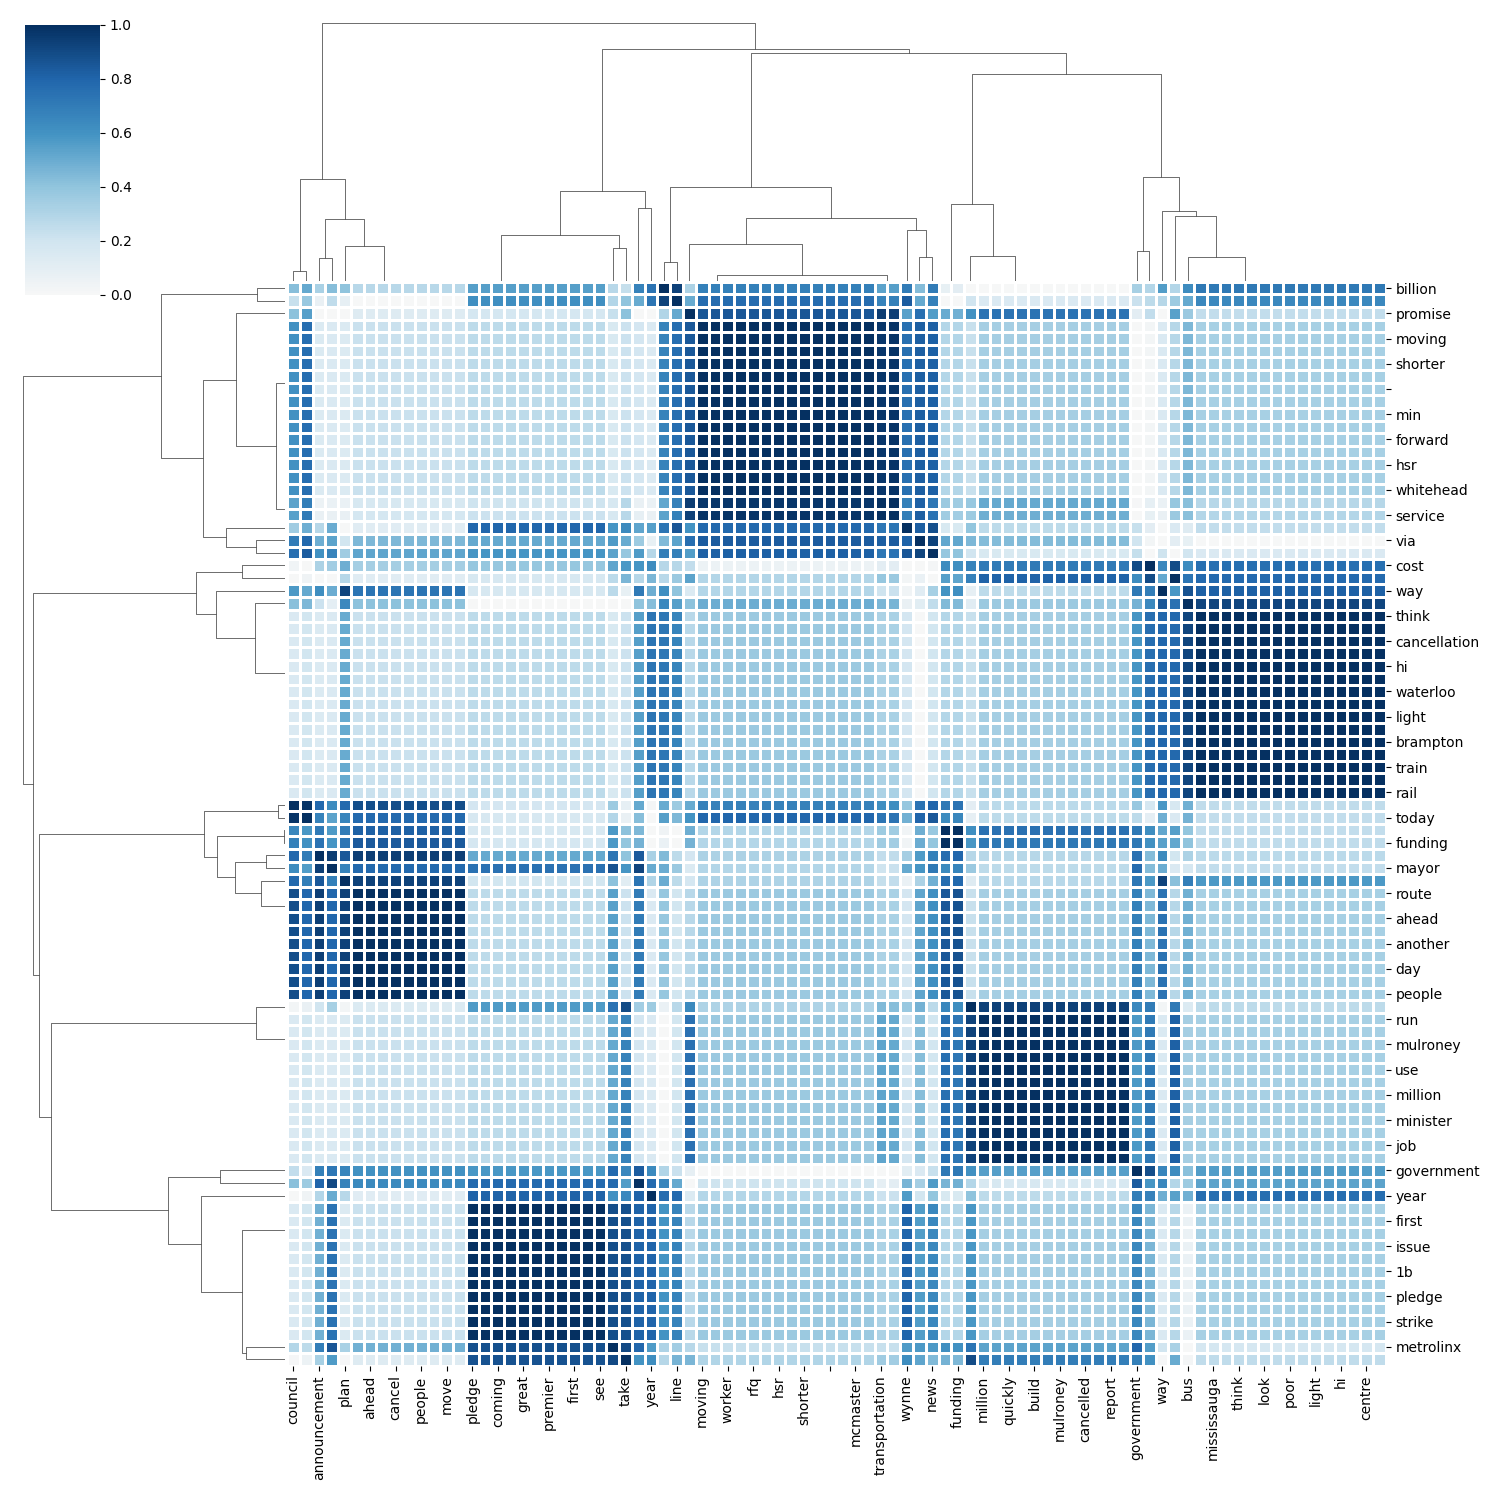

In [302]:
# visualise the correlation between words
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()



In [303]:
# visualize the topics 
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  47.055758
4       51.163364 -159.968018       2        1  22.612885
2      -73.144554   21.523815       3        1  10.127346
3      -66.410133 -110.606438       4        1  10.109561
1       54.417324   12.443444       5        1  10.094449, topic_info=                Term       Freq      Total Category  logprob  loglift
212   transportation  20.000000  20.000000  Default  30.0000  30.0000
1670                   8.000000   8.000000  Default  29.0000  29.0000
98           service  25.000000  25.000000  Default  28.0000  28.0000
317              bus  26.000000  26.000000  Default  27.0000  27.0000
497             cost  19.000000  19.000000  Default  26.0000  26.0000
1492           mayor  20.000000  20.000000  Default  25.0000  25.0000
518          promise  10.000000  10.000000  Default  24.0000  24.0000
240             line  17.000000  17.000000  Default  23.0000  23.0000
30              back  10.000000  10.000000  Default  22.0000  22.0000
754        metrolinx  17.000000  17.000000  Default  21.0000  21.0000
417              via  37.000000  37.000000  Default  20.0000  20.0000
521          billion  25.000000  25.000000  Default  19.0000  19.0000
489           centre   8.000000   8.000000  Default  18.0000  18.0000
4673             rfq   5.000000   5.000000  Default  17.0000  17.0000
273       government  23.000000  23.000000  Default  16.0000  16.0000
3222          update   7.000000   7.000000  Default  15.0000  15.0000
1778              hi   5.000000   5.000000  Default  14.0000  14.0000
405          student   7.000000   7.000000  Default  13.0000  13.0000
625             rail   6.000000   6.000000  Default  12.0000  12.0000
589           design   7.000000   7.000000  Default  11.0000  11.0000
3518         shorter   7.000000   7.000000  Default  10.0000  10.0000
5163       whitehead   4.000000   4.000000  Default   9.0000   9.0000
5187          strike  10.000000  10.000000  Default   8.0000   8.0000
5386           wynne  12.000000  12.000000  Default   7.0000   7.0000
332             take  13.000000  13.000000  Default   6.0000   6.0000
333            train  10.000000  10.000000  Default   5.0000   5.0000
1582           light   4.000000   4.000000  Default   4.0000   4.0000
32           funding  16.000000  16.000000  Default   3.0000   3.0000
1621         premier   7.000000   7.000000  Default   2.0000   2.0000
352      mississauga   4.000000   4.000000  Default   1.0000   1.0000
4746           chair   6.780691   6.846552   Topic1  -5.8958   0.7442
502              aim   5.853565   5.924462   Topic1  -6.0428   0.7418
4784   privatization   5.316452   5.381361   Topic1  -6.1391   0.7417
729             ramp   5.909900   5.988818   Topic1  -6.0332   0.7406
503       cincinnati   4.332009   4.402716   Topic1  -6.3438   0.7376
5021             war   3.703803   3.764804   Topic1  -6.5005   0.7375
719               bc   4.336266   4.424540   Topic1  -6.3428   0.7337
436          speaker   2.961476   3.024438   Topic1  -6.7242   0.7328
3516       direction   2.796065   2.858303   Topic1  -6.7816   0.7318
3803          hurdle   2.397971   2.458516   Topic1  -6.9352   0.7289
685             pain   2.306940   2.368861   Topic1  -6.9739   0.7273
4127      soundtrack   2.303477   2.365726   Topic1  -6.9754   0.7272
3989        sidewalk   2.257950   2.323165   Topic1  -6.9954   0.7254
1392         crucial   4.360613   4.487657   Topic1  -6.3372   0.7251
4797          gather   2.086165   2.148307   Topic1  -7.0745   0.7245
4177           urged   2.595525   2.676462   Topic1  -6.8561   0.7231
1316           stuck   2.008545   2.072740   Topic1  -7.1124   0.7224
3141       queenston   1.953842   2.018317   Topic1  -7.1401   0.7214
3721     stakeholder   1.755611   1.816434   Topic1  -7.2470   0.7198
1733         sharing   2.533401   2.626481   Topic1

### Topic

In [304]:
# looking at the top 10 keywords each topic 

num_topics = lda.num_topics
num_words = 10

for i in range(num_topics):
    print(f"Topic {i}:")
    topic_words = lda.show_topic(i, num_words)
    print([word for word, prob in topic_words])


Topic 0:
['announcement', 'plan', 'cancel', 'people', 'council', 'via', 'move', 'mayor', 'support', 'government']
Topic 1:
['back', 'cost', 'via', 'government', 'support', 'promise', 'report', 'job', 'use', 'one']
Topic 2:
['bus', 'centre', 'billion', 'cost', 'hi', 'rail', 'line', 'government', 'mississauga', 'light']
Topic 3:
['via', 'metrolinx', 'mayor', 'billion', 'line', 'government', 'strike', 'take', 'make', 'wynne']
Topic 4:
['service', 'transportation', 'via', '', 'billion', 'line', 'student', 'promise', 'design', 'news']


In [305]:
# createing a df to store topong and keywords
num_topics = lda.num_topics
num_words = 30
lambda_value = 0.5

topic_word_dict = {}
for i in range(num_topics):
    topic_words = lda.show_topic(i, num_words)
    word_list = [word for word, prob in topic_words]
    prob_list = [prob for word, prob in topic_words]
    adjusted_prob_list = [(1 - lambda_value) * prob + lambda_value * (1/num_topics) for prob in prob_list]
    topic_word_dict[f"Topic {i}"] = word_list
    
df_topic_pred = pd.DataFrame(topic_word_dict)
df_topic_pred
    

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,announcement,back,bus,via,service
1,plan,cost,centre,metrolinx,transportation
2,cancel,via,billion,mayor,via
3,people,government,cost,billion,
4,council,support,hi,line,billion
5,via,promise,rail,government,line
6,move,report,line,strike,student
7,mayor,job,government,take,promise
8,support,use,mississauga,make,design
9,government,one,light,wynne,news


#### Topic renaming using GPT-3 Language Modeling based on top 10 keywords 
- Topic 0: "Government Support and Decision-Making"
- Topic 1: "Cost of Transportation and Government Promises"
- Topic 2: "Public Transportation Options and Costs"
- Topic 3: "Metrolinx and Government Actions"
- Topic 4: "Transportation Services and News Updates"

In [306]:
# assume your topic names are stored in a list called "topic_names"
topic_names = [
    "Government Support and Decision-Making", 
    "Cost of Transportation and Government Promises", 
    "Public Transportation Options and Costs", 
    "Metrolinx and Government Actions", 
    "Transportation Services and News Updates"
    ]

# rename the columns to the topic names
df_topic_pred = df_topic_pred.rename(columns={f"Topic {i}": topic_names[i] for i in range(len(topic_names))})

<h2>Topic assignment using trained LDA model with TF-IDF in Python</h2>

<ul>
  <li>Import the necessary libraries: <code>sklearn.feature_extraction.text.CountVectorizer</code> and <code>gensim.corpora.Dictionary</code>.</li>
  <li>Instantiate a CountVectorizer object.</li>
  <li>Fit and transform the cleaned text data to create a document-term matrix using the CountVectorizer object.</li>
  <li>Convert the document-term matrix to a Pandas dataframe.</li>
  <li>Create a Bag-of-Words (BoW) corpus using the cleaned text data.</li>
  <li>Instantiate an LDA model and train it on the BoW corpus using the gensim library.</li>
  <li>Get the topic distribution for each document in the corpus using the LDA model.</li>
  <li>Extract the topic with the highest probability for each document.</li>
  <li>Add the topic column to the original dataframe.</li>
</ul>

In [309]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary

vectorizer = CountVectorizer()
# fit and transform the cleaned_words_c column to create a document-term matrix
doc_term_matrix = vectorizer.fit_transform(df['cleaned_words_c'].apply(lambda x: ' '.join(x)))

# convert the document-term matrix to a pandas dataframe
doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns=vectorizer.get_feature_names())

bow_corpus = [dictionary.doc2bow(tweet) for tweet in df['cleaned_words_c']]

# create an LDA model and train it on the bag-of-words corpus
lda = LdaModel(bow_corpus, num_topics=5, id2word=dictionary)

# get the topic distribution for each tweet
topic_distribution = lda.get_document_topics(bow_corpus)

# extract the topic with the highest probability for each tweet
topics = [max(topic, key=lambda x: x[1])[0] for topic in topic_distribution]

# add the topic column to the original dataframe
df['topic'] = topics


2023-05-24 18:08:00,755 : INFO : using symmetric alpha at 0.2
2023-05-24 18:08:00,757 : INFO : using symmetric eta at 0.2
2023-05-24 18:08:00,760 : INFO : using serial LDA version on this node
2023-05-24 18:08:00,775 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 5238 documents, updating model once every 2000 documents, evaluating perplexity every 5238 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-24 18:08:00,776 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-24 18:08:00,782 : INFO : PROGRESS: pass 0, at document #2000/5238
2023-05-24 18:08:02,370 : INFO : merging changes from 2000 documents into a model of 5238 documents
2023-05-24 18:08:02,374 : INFO : topic #0 (0.200): 0.009*"bus" + 0.007*"government" + 0.006*"cost" + 0.006*"service" + 0.005*"help" + 0.004*"doug" + 0.004*"federal" + 0.004*"affordable" + 0.004*"y

In [310]:
# create a dictionary to map topic numbers to their names
topic_dict = {
    0: "Government Support and Decision-Making",
    1: "Cost of Transportation and Government Promises",
    2: "Public Transportation Options and Costs",
    3: "Metrolinx and Government Actions",
    4: "Transportation Services and News Updates",
}

# apply the mapping to the current column using the map() function
df['topic'] = df['topic'].map(topic_dict)


In [311]:
# visualie the data frame
df.head(1)


,Tweet content,Date,Location,Hashtags,Dates,Time,day,month,year,mentions,cleaned_tweets,polarity,Sentiment,words,cleaned_words,cleaned_words_c,topic
0,"Hamilton PSA Road Delay. Last Week.\n\nUNM PATS is notifying the UNM community to expect HEAVY VEHICLE AND FOOT TRAFFIC from May 22 to May 28, due to special events, including the Hamilton Broadway Musical at Popejoy Hall.\n\nRead the full notice at https://t.co/m0FXPO48dJ https://t.co/hZEnc4t78p",2023-05-22 23:00:00,"Albuquerque, NM",[],2023-05-22,23:00:00,22,5,2023,[],psa road delay last week unm pats notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special events including broadway musical popejoy hall read full notice,0.1027,Negative,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",psa road delay last week unm pat notifying unm community expect heavy vehicle foot traffic may 22 may 28 due special event including broadway musical popejoy hall read full notice,"[psa, road, delay, last, week, unm, pat, notifying, unm, community, expect, heavy, vehicle, foot, traffic, may, 22, may, 28, due, special, event, including, broadway, musical, popejoy, hall, read, full, notice]",Metrolinx and Government Actions


<AxesSubplot:>

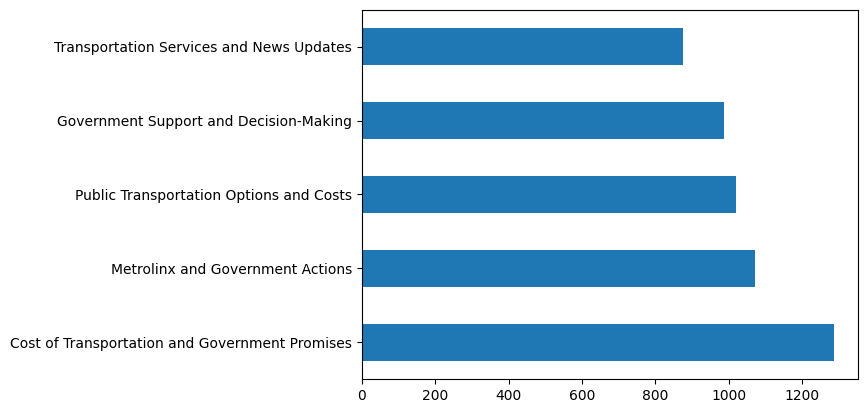

In [312]:
df['topic'].value_counts().plot(kind = 'barh')

<AxesSubplot:ylabel='topic'>

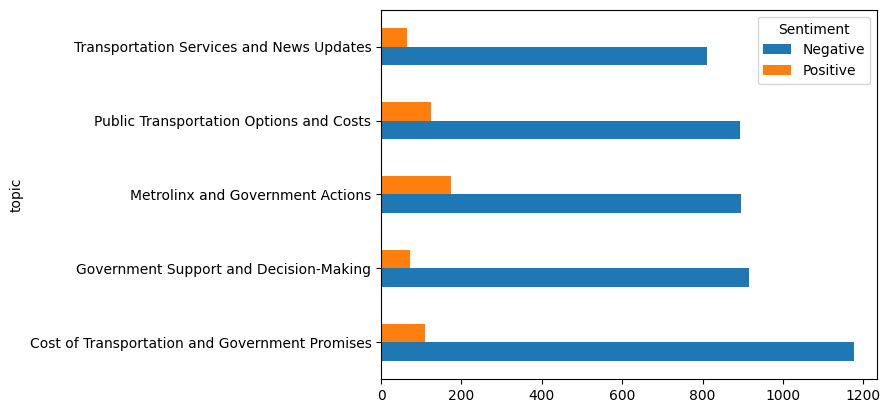

In [313]:
df_topic = pd.crosstab(df['topic'],df['Sentiment']).reset_index()
df_topic.plot(x = 'topic', kind = 'barh')


In [254]:
# Search for tweets containing a specific string
search_string = "wynne"  # Replace with your desired search string

# Use str.contains() to filter tweets
filtered_df = df[df['cleaned_tweets'].str.contains(search_string, case=True)]
filtered_df.head(15)

,Tweet content,Date,Location,Hashtags,Dates,Time,day,month,year,mentions,cleaned_tweets,polarity,Sentiment,words,cleaned_words,cleaned_words_c,topic
2033,"@JohnPaulDanko ""You're screwing us over, madam,"" said the ever-quotable Merulla. Downloading costs continue to be an issue for Hamilton &amp; other municipalities. Merulla said he was trying to get her attn\n\n2 years later, Wynne announced $1B for Hamilton LRT, so she must not have felt too burned",2020-01-23 00:26:10,No location provided,[],2020-01-23,00:26:10,23,1,2020,[JohnPaulDanko],screwing madam said quotable merulla downloading costs continue issue municipalities merulla said trying attn years later wynne announced 1b must felt burned,-0.2263,Negative,"[screwing, madam, said, quotable, merulla, downloading, cost, continue, issue, municipality, merulla, said, trying, attn, year, later, wynne, announced, 1b, must, felt, burned]",screwing madam said quotable merulla downloading cost continue issue municipality merulla said trying attn year later wynne announced 1b must felt burned,"[screwing, madam, said, quotable, merulla, downloading, cost, continue, issue, municipality, merulla, said, trying, attn, year, later, wynne, announced, 1b, must, felt, burned]",Government Support and News Announcements
2778,"@CP24 why would you have that lying skanky bitch Wynne on the news tonight regarding the Hamilton LRT??? She’s a liar. She wasted billions. She’s irrelevant. She killed her political party. She’s twisted. She’s immoral, She and McSquinty killed Ontario",2019-12-17 00:18:50,No location provided,[],2019-12-17,00:18:50,17,12,2019,[CP24],lying skanky bitch wynne news tonight regarding liar wasted billions irrelevant killed political party twisted immoral mcsquinty killed,-0.9750,Negative,"[lying, skanky, bitch, wynne, news, tonight, regarding, liar, wasted, billion, irrelevant, killed, political, party, twisted, immoral, mcsquinty, killed]",lying skanky bitch wynne news tonight regarding liar wasted billion irrelevant killed political party twisted immoral mcsquinty killed,"[lying, skanky, bitch, wynne, news, tonight, regarding, liar, wasted, billion, irrelevant, killed, political, party, twisted, immoral, mcsquinty, killed]",Government Support and News Announcements
2858,"Ford govt cancels Hamilton LRT, but we avoided that ""NDP ideology"" Kathleen Wynne warned everyone about. #onpoli https://t.co/mzjroEre0o",2019-12-16 20:56:02,"Toronto, Ontario",[#onpoli],2019-12-16,20:56:02,16,12,2019,[],govt cancels avoided ndp ideology kathleen wynne warned everyone,-0.6597,Negative,"[govt, cancel, avoided, ndp, ideology, kathleen, wynne, warned, everyone]",govt cancel avoided ndp ideology kathleen wynne warned everyone,"[govt, cancel, avoided, ndp, ideology, kathleen, wynne, warned, everyone]",Opinions on Plan Cancellation and Costs
2863,"1. Mulroney's statement on the #Hamilton LRT highlights a huge ethical problem, but not the one she apparently intended to make: It was #Metrolinx's job to release that figure to the public in a timely fashion whether Wynne &amp; Co. wanted to the public to know or not. #onpoli",2019-12-16 20:52:48,43.6532° N 79.3832° W Tkaranto,"[#Hamilton, #Metrolinx's, #onpoli]",2019-12-16,20:52:48,16,12,2019,[],mulroney statement highlights huge ethical problem one apparently intended make job release figure timely fashion whether wynne co wanted know,0.4404,Positive,"[mulroney, statement, highlight, huge, ethical, problem, one, apparently, intended, make, job, release, figure, timely, fashion, whether, wynne, co, wanted, know]",mulroney statement highlight huge ethical problem one apparently intended make job release figure timely fashion whether wynne co wanted know,"[mulroney, statement, highlight, huge, ethical, problem, one, apparently, intended, make, job, release, figure, timely, fashion, whether, wynne, co, wanted, know]",Opinions on Plan Cancellation and Costs
3173,"@JeffYurekMPP Hello! Hamilton LRT not needed. Unnecessary, expensive Wynne Liberal lega

In [253]:
filtered_df['Sentiment'].value_counts()

Positive    55
Negative     7
Neutral      6
Name: Sentiment, dtype: int64

In [ ]:
# Group the data by user and sum the replyCount for each user
grouped_df_4 = df.groupby(['User','topic','Sentiment']).agg(
    meanReplyCount=('replyCount', np.mean),
    meanLike_Count=('Like_Count', np.mean)).reset_index()


In [ ]:
use_count = pd.DataFrame(df['User'].value_counts().reset_index()).rename(columns = {'index': 'User', 'User':'Count'})
use_count.head()

In [ ]:
# Merge the data with the original DataFrame to get the sentiment information
merged_df_4 = pd.merge(grouped_df_4, use_count, on='User', how='inner')
merged_df_4.head()


In [ ]:
df0 = pd.DataFrame(topic_term_dist[0][1])
df1 = pd.DataFrame(topic_term_dist[1][1])
df2 = pd.DataFrame(topic_term_dist[2][1])
df3 = pd.DataFrame(topic_term_dist[3][1])
df4 = pd.DataFrame(topic_term_dist[4][1])

frames = [df0,df1, df2, df3, df4]

result = pd.concat(frames).reset_index()

top_list = []
for j in topic_names:
    for i in range(10):
        top_list.append(j)
df5 = pd.DataFrame(top_list).rename(columns = {0:'Topic'})
df5 = pd.concat([result,df5], axis = 1)
df5

In [ ]:
# df.groupby('Dates')['topic'].count()
grouped_df = df.groupby(['topic', 'Sentiment'])['ID'].count().reset_index()

# Remove the neutral sentiment
grouped_df = grouped_df[grouped_df['Sentiment'] != 'Neutral']
grouped_df
# Plot the data in a stacked bar chart
# fig = px.bar(grouped_df, x='topic', y='ID', color='Sentiment', barmode='stack', color_discrete_sequence=['red', 'green'])

# # Update the layout of the chart
# fig.update_layout(title={
#     'text': "Top 10 Users with the Most Reply Count",
#     'font': {'size': 24}
# })


# fig.show()

### Overall sentiment:

>Mix of positive and negative sentiment
Users appreciate care from healthcare providers and private options
Concerns about public aspects of healthcare system and government's role in providing and funding healthcare
Possible business objective:

>Identify specific areas of healthcare system causing negative sentiment
Target resources towards improving these areas
Improve public perception of Canadian healthcare system 

In [246]:
pyLDAvis.save_json(panel, 'tclda.json')
pyLDAvis.save_html(panel, 'tclda.html')

### assign names to particular topics
def add_topics_names(tlist, tnames, json_data):
    data1=json_data
    atop = len(data1['mdsDat']['topics'])
    assigned_names= np.arange(1, atop+1).tolist()
    for i,j in enumerate(tlist):
        assigned_names[j]=tnames[i]
    data1['mdsDat']['topic.names']=assigned_names
    return data1

#ldavis preffs
topics_to_name = [0,1,2,3,4]
topics_names = ['Politics and Public Opinion','Healthcare Access and Treatment','Government and Healthcare Funding','COVID-19 Pandemic and Vaccination','Healthcare Costs and Taxes']

#loading saved json file
with open('tclda1.json') as data_file:    
    data = json.load(data_file)
#Calling function change names
data=add_topics_names(topics_to_name, topics_names, data)
#save json file
with open('tclda.json', 'w') as fp:
    json.dump(data, fp)

FileNotFoundError: [Errno 2] No such file or directory: 'tclda1.json'